# CHEST X-RAY ABNOMALITY DETECTION: YOLOv5

## 1 Análisis Exploratorio

### 1.1 Cargamos librerías

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
from skimage import exposure
from keras.preprocessing.image import load_img
import cv2
from IPython.display import SVG, display, clear_output
from matplotlib.ticker import MaxNLocator
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

### 1.2 Inicializamos Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1.3 Carga y exploración de datos

In [ ]:
train = glob("/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/train/*.png")

#### 1.3.1 Exploramos el dataset de imágenes y csv de características.

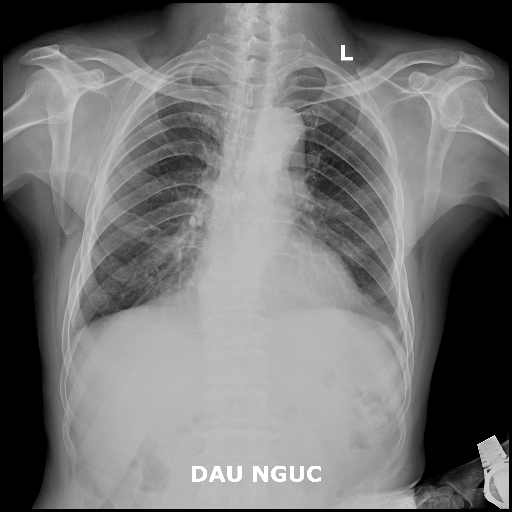

In [ ]:
load_img(train[3])

In [ ]:
train[3].split(sep = '/')[7].split(sep = '.')[0]

'ed6b8aafbebda034d02fb57cbe7a2439'

In [ ]:
train_info = pd.read_csv('/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/train.csv')

In [ ]:
train_info.head()

image_id          class_name  ...  width height
0  50a418190bc3fb1ef1633bf9678929b3          No finding  ...   2332   2580
1  21a10246a5ec7af151081d0cd6d65dc9          No finding  ...   2954   3159
2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly  ...   2080   2336
3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement  ...   2304   2880
4  063319de25ce7edb9b1c6b8881290140          No finding  ...   2540   3072

[5 rows x 10 columns]

In [ ]:
train_info.describe()

class_id         x_min  ...         width        height
count  67914.000000  36096.000000  ...  67914.000000  67914.000000
mean       9.979312   1051.332696  ...   2474.954280   2816.755205
std        5.036494    565.838078  ...    360.818872    297.959417
min        0.000000      0.000000  ...    823.000000    927.000000
25%        7.000000    602.000000  ...   2256.000000   2500.000000
50%       13.000000   1014.500000  ...   2425.000000   2880.000000
75%       14.000000   1457.000000  ...   2718.000000   3072.000000
max       14.000000   2934.000000  ...   3320.000000   3408.000000

[8 rows x 7 columns]

In [ ]:
train_info.isna().sum()

image_id          0
class_name        0
class_id          0
rad_id            0
x_min         31818
y_min         31818
x_max         31818
y_max         31818
width             0
height            0
dtype: int64

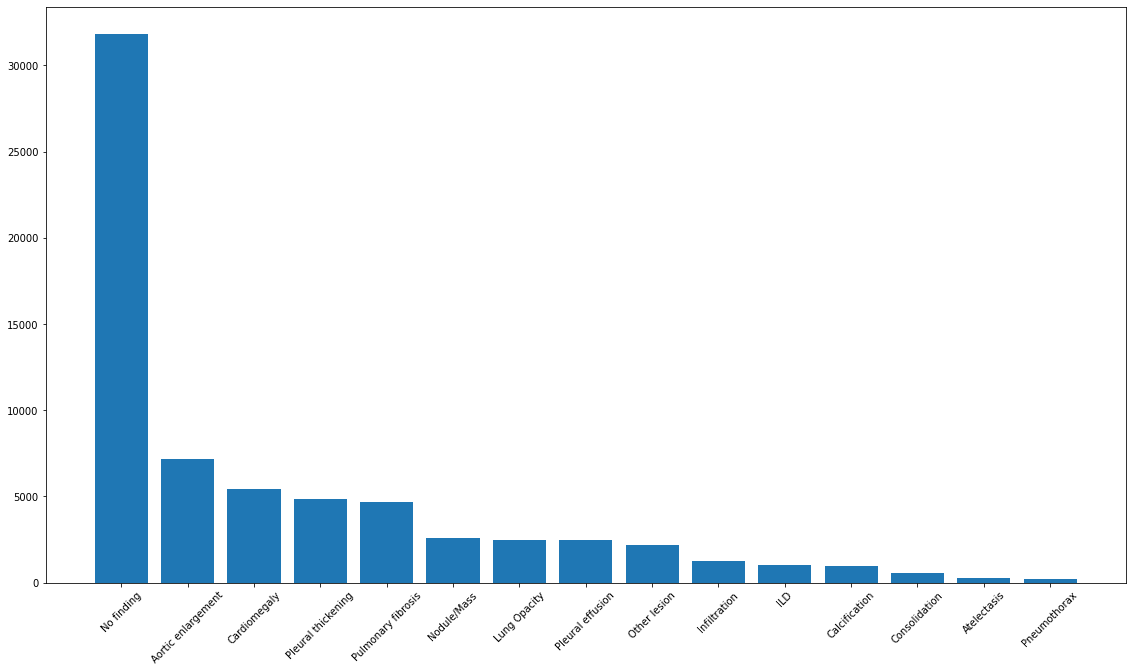

In [ ]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_axes([0,0,1,1])

X = train_info.class_name.value_counts().index
Y = train_info.class_name.value_counts()
ax.bar(X,Y)
ax.set_xticklabels(train_info.class_name.value_counts().index, rotation=45 )
plt.show()

In [ ]:
train_info.image_id.value_counts()

03e6ecfa6f6fb33dfeac6ca4f9b459c9    57
fa109c087e46fe1ea27e48ce6d154d2f    52
e31be972e181987a8600a8700c1ebe88    48
6d5acf3f8a973a26844d617fffe72998    46
ecf474d5d4f65d7a3e23370a68b8c6a0    46
                                    ..
f737d59bfbd9baeb93f351676ba5ac5a     3
a2c8aa4adf9ec69fba7ec2df32075709     3
96923fac3f812873938b5fb7280eb12d     3
5a702a2d9f3b17f32b0b4e7f67967ff7     3
7115757536c23160b8aed5f2f41c9f50     3
Name: image_id, Length: 15000, dtype: int64

In [ ]:
len(train_info.image_id.unique())

15000

The number of "No finding" is the same that the number of NA in coordinates (x, y) values.

#### 1.3.2 Filtramos por aquellos registros en los que se ha localizado alguna anomalía. Diferentes de "No finding".

In [ ]:
train_info_finds = train_info[train_info.class_id != 14]

In [ ]:
train_info_finds.describe()

class_id         x_min  ...         width        height
count  36096.000000  36096.000000  ...  36096.000000  36096.000000
mean       6.435145   1051.332696  ...   2521.028923   2864.700327
std        4.573290    565.838078  ...    342.502044    283.181526
min        0.000000      0.000000  ...   1572.000000   1712.000000
25%        3.000000    602.000000  ...   2304.000000   2746.000000
50%        7.000000   1014.500000  ...   2496.000000   2880.000000
75%       11.000000   1457.000000  ...   2765.000000   3072.000000
max       13.000000   2934.000000  ...   3320.000000   3408.000000

[8 rows x 7 columns]

In [ ]:
train_info_finds.isna().sum()

image_id      0
class_name    0
class_id      0
rad_id        0
x_min         0
y_min         0
x_max         0
y_max         0
width         0
height        0
dtype: int64

In [ ]:
train_info_finds.class_name.value_counts()

Aortic enlargement    7162
Cardiomegaly          5427
Pleural thickening    4842
Pulmonary fibrosis    4655
Nodule/Mass           2580
Lung Opacity          2483
Pleural effusion      2476
Other lesion          2203
Infiltration          1247
ILD                   1000
Calcification          960
Consolidation          556
Atelectasis            279
Pneumothorax           226
Name: class_name, dtype: int64

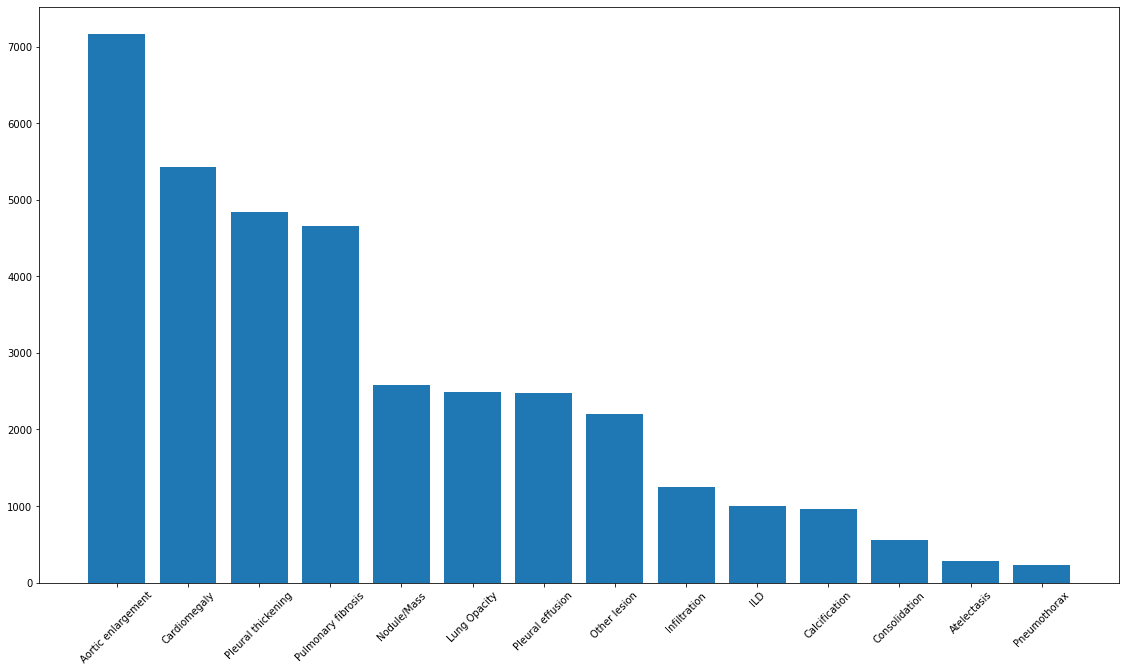

In [ ]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_axes([0,0,1,1])

X = train_info_finds.class_name.value_counts().index
Y = train_info_finds.class_name.value_counts()
ax.bar(X,Y)
ax.set_xticklabels(train_info_finds.class_name.value_counts().index, rotation=45 )
plt.show()

In [ ]:
len(train_info_finds.image_id.unique())

4394

### 1.4 Redimensionamos las coordenadas (x , y) para el nuevo tamaño de imagen (512x512). 

In [ ]:
def normalize_cod(df):
    df.x_min= (df.x_min/ df.width)* 512
    df.x_max= (df.x_max/ df.width)* 512
    
    df.y_min= (df.y_min/ df.height)* 512
    df.y_max= (df.y_max/ df.height)* 512
    return df

In [ ]:
train_info = normalize_cod(train_info)

### 1.5 Visualizamos algunas imágenes y pintamos las anotaciones (clases) y la localización de estas (bounding boxes).

ecadf9a1eca2152b13f18d3a0b8bfba4


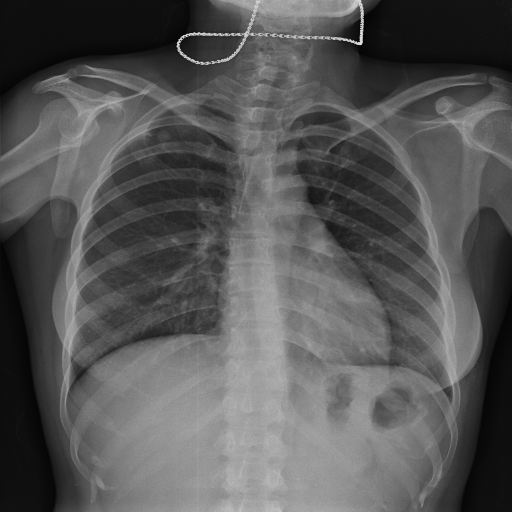

edcd888b39a328f3beaa2b6ffbc4aecd


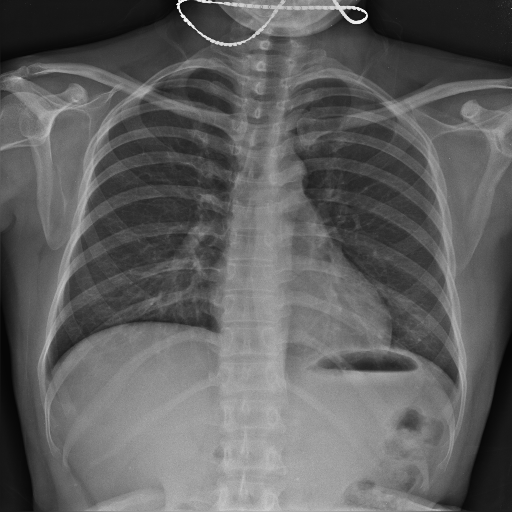

ebd651e0daa599792382d0f98e6c036a


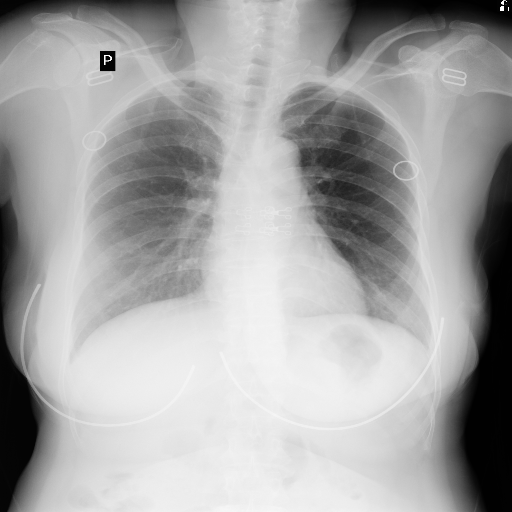

ed6b8aafbebda034d02fb57cbe7a2439


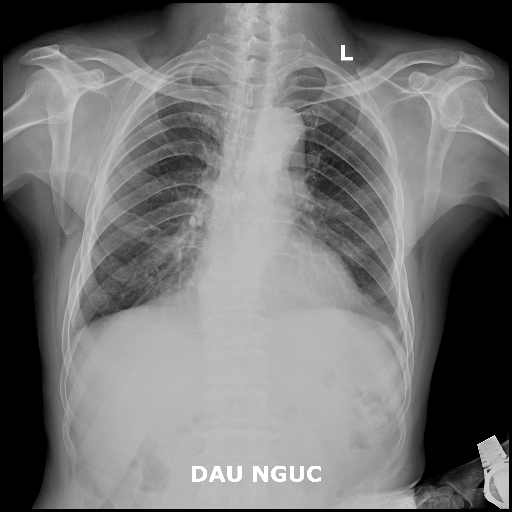

ec0d8eda3ff0b4fe8d3a7a7b795fed21


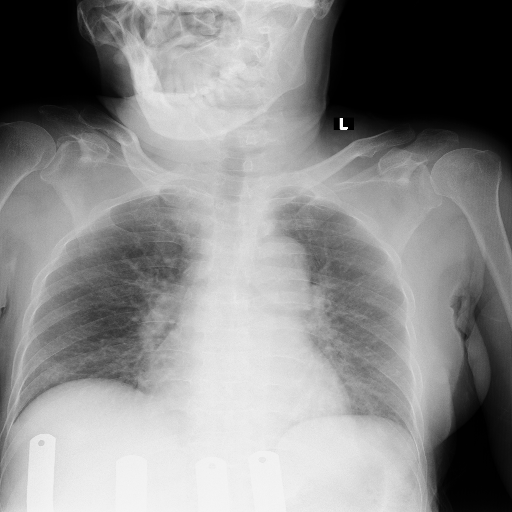

In [ ]:
from google.colab.patches import cv2_imshow
for i in train[:5]:
  img = cv2.imread(i)
  print(i.split(sep = '/')[7].split(sep = '.')[0])
  cv2_imshow(img)

Creamos la función para mostrar las imágenes con sus bounding boxes y clases.

In [ ]:
def plot_all_annotations(df_item, path, hide_axis = False, predicted_df_item = None):
    
    # Convert the x-ray image into RGB
    
    image = cv2.imread(path)

    
    # Create figure
    plt.figure(figsize = (10,10))
    plt.title("Image ID - {}".format(df_item.iloc[0]["image_id"]))
    
    for index,item in df_item.iterrows():
        
        #if (np.isnan(item["x_min"]) and np.isnan(item["y_min"])):
        #    continue

        # Declare coordinates and convert them to integers
        x_min = int(item["x_min"])
        y_min = int(item["y_min"])
        x_max = int(item["x_max"])
        y_max = int(item["y_max"])

        # Create rectangle where the annotation is located
        image = cv2.rectangle(img=image,rec=(x_min,y_min,x_max-x_min,y_max-y_min), color = (0,255,0),thickness = 2)

        # Add label to the annotation
        image = cv2.putText(image, item["class_name"], (int(item["x_min"]),int(item["y_min"])), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0,0,0), thickness=1)

                
    # Plot image
    plt.imshow(image)
    
    # Select if axis should be hidden
    if hide_axis:
        plt.axis("Off")
    plt.show()

Filtramos por el image_id will que vamos a pintar.

In [ ]:
image_ids = train_info['image_id'].unique()
image_annotations = train_info.loc[train_info['image_id'].isin([train[3].split(sep = '/')[7].split(sep = '.')[0]])]
image_annotations

image_id          class_name  ...  width height
19135  ed6b8aafbebda034d02fb57cbe7a2439  Aortic enlargement  ...   3072   3072
20179  ed6b8aafbebda034d02fb57cbe7a2439  Aortic enlargement  ...   3072   3072
27379  ed6b8aafbebda034d02fb57cbe7a2439  Aortic enlargement  ...   3072   3072
44989  ed6b8aafbebda034d02fb57cbe7a2439        Cardiomegaly  ...   3072   3072

[4 rows x 10 columns]

Print image and all of its annotations calling the plot annotetions function.
Mostramos la imagen con todas sus anotaciones llamando a la función creada anteriormente.

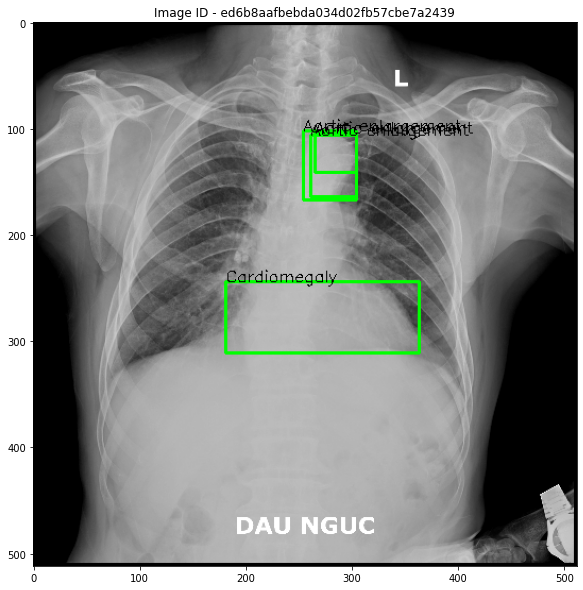

In [ ]:
plot_all_annotations(image_annotations, train[3], hide_axis = False)

In [ ]:
image_ids = train_info['image_id'].unique()
image_annotations = train_info.loc[train_info['image_id'].isin([train[100].split(sep = '/')[7].split(sep = '.')[0]])]
image_annotations

image_id          class_name  ...  width height
2020   f0dea85c5527d47a3b7f4227813f0b95       Consolidation  ...   2304   2880
20076  f0dea85c5527d47a3b7f4227813f0b95  Pulmonary fibrosis  ...   2304   2880
22702  f0dea85c5527d47a3b7f4227813f0b95        Lung Opacity  ...   2304   2880
29743  f0dea85c5527d47a3b7f4227813f0b95    Pleural effusion  ...   2304   2880
33559  f0dea85c5527d47a3b7f4227813f0b95    Pleural effusion  ...   2304   2880
53041  f0dea85c5527d47a3b7f4227813f0b95    Pleural effusion  ...   2304   2880

[6 rows x 10 columns]

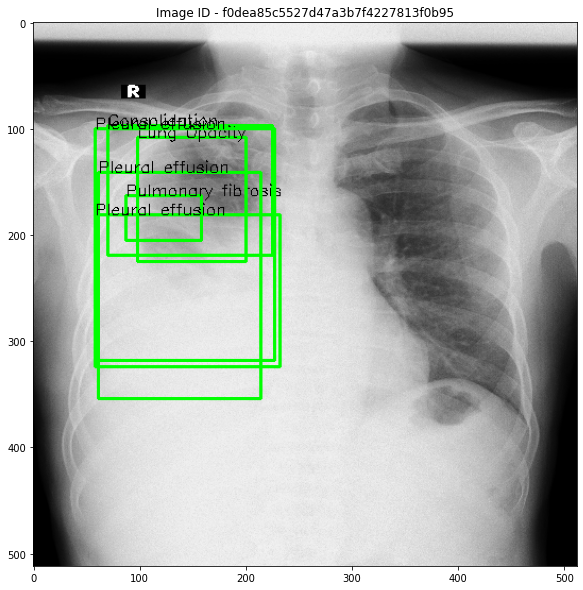

In [ ]:
plot_all_annotations(image_annotations, train[100], hide_axis = False)

In [ ]:
image_ids = train_info['image_id'].unique()
image_annotations = train_info.loc[train_info['image_id'].isin([train[400].split(sep = '/')[7].split(sep = '.')[0]])]
image_annotations

image_id          class_name  ...  width height
23696  f680a42a3444d3739c5552face67bf18        Cardiomegaly  ...   2304   2880
27286  f680a42a3444d3739c5552face67bf18  Aortic enlargement  ...   2304   2880
31070  f680a42a3444d3739c5552face67bf18        Cardiomegaly  ...   2304   2880
34216  f680a42a3444d3739c5552face67bf18  Aortic enlargement  ...   2304   2880
44007  f680a42a3444d3739c5552face67bf18  Pleural thickening  ...   2304   2880
44887  f680a42a3444d3739c5552face67bf18  Pleural thickening  ...   2304   2880
63259  f680a42a3444d3739c5552face67bf18        Cardiomegaly  ...   2304   2880
66024  f680a42a3444d3739c5552face67bf18  Aortic enlargement  ...   2304   2880

[8 rows x 10 columns]

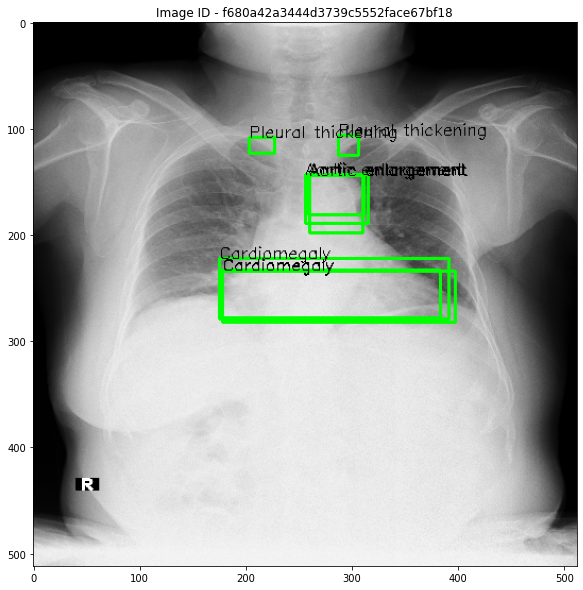

In [ ]:
plot_all_annotations(image_annotations, train[400], hide_axis = False)

## 2 MODELADO

### 2.1 Importamos las librerías y los datos

In [ ]:
import numpy as np 
import pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/train.csv')
train_df.head()

image_id          class_name  ...  width height
0  50a418190bc3fb1ef1633bf9678929b3          No finding  ...   2332   2580
1  21a10246a5ec7af151081d0cd6d65dc9          No finding  ...   2954   3159
2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly  ...   2080   2336
3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement  ...   2304   2880
4  063319de25ce7edb9b1c6b8881290140          No finding  ...   2540   3072

[5 rows x 10 columns]

In [ ]:
train_df['image_path'] = '/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/train/' + train_df['image_id'] + '.png'
train_df.head()

image_id  ...                                         image_path
0  50a418190bc3fb1ef1633bf9678929b3  ...  /content/drive/MyDrive/000_PROYECTO DL/vinbigd...
1  21a10246a5ec7af151081d0cd6d65dc9  ...  /content/drive/MyDrive/000_PROYECTO DL/vinbigd...
2  9a5094b2563a1ef3ff50dc5c7ff71345  ...  /content/drive/MyDrive/000_PROYECTO DL/vinbigd...
3  051132a778e61a86eb147c7c6f564dfe  ...  /content/drive/MyDrive/000_PROYECTO DL/vinbigd...
4  063319de25ce7edb9b1c6b8881290140  ...  /content/drive/MyDrive/000_PROYECTO DL/vinbigd...

[5 rows x 11 columns]

In [ ]:
train_df = train_df[train_df.class_id!=14].reset_index(drop = True)
train_df.head()

image_id  ...                                         image_path
0  9a5094b2563a1ef3ff50dc5c7ff71345  ...  /content/drive/MyDrive/000_PROYECTO DL/vinbigd...
1  051132a778e61a86eb147c7c6f564dfe  ...  /content/drive/MyDrive/000_PROYECTO DL/vinbigd...
2  1c32170b4af4ce1a3030eb8167753b06  ...  /content/drive/MyDrive/000_PROYECTO DL/vinbigd...
3  0c7a38f293d5f5e4846aa4ca6db4daf1  ...  /content/drive/MyDrive/000_PROYECTO DL/vinbigd...
4  47ed17dcb2cbeec15182ed335a8b5a9e  ...  /content/drive/MyDrive/000_PROYECTO DL/vinbigd...

[5 rows x 11 columns]

### 2.2 Realizamos el pre procesado de los datos, para prepararlos para el modelo.

In [ ]:
train_df['x_min'] = train_df.apply(lambda row: (row.x_min)/row.width, axis =1)
train_df['y_min'] = train_df.apply(lambda row: (row.y_min)/row.height, axis =1)

train_df['x_max'] = train_df.apply(lambda row: (row.x_max)/row.width, axis =1)
train_df['y_max'] = train_df.apply(lambda row: (row.y_max)/row.height, axis =1)

train_df['x_mid'] = train_df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
train_df['y_mid'] = train_df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

train_df['w'] = train_df.apply(lambda row: (row.x_max-row.x_min), axis =1)
train_df['h'] = train_df.apply(lambda row: (row.y_max-row.y_min), axis =1)

train_df['area'] = train_df['w']*train_df['h']
train_df.head()

image_id          class_name  ...         h      area
0  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly  ...  0.195205  0.090283
1  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement  ...  0.095833  0.014433
2  1c32170b4af4ce1a3030eb8167753b06  Pleural thickening  ...  0.024740  0.003117
3  0c7a38f293d5f5e4846aa4ca6db4daf1                 ILD  ...  0.753033  0.277156
4  47ed17dcb2cbeec15182ed335a8b5a9e         Nodule/Mass  ...  0.039368  0.001809

[5 rows x 16 columns]

In [ ]:
features = ['x_min', 'y_min', 'x_max', 'y_max', 'x_mid', 'y_mid', 'w', 'h', 'area']
X = train_df[features]
y = train_df['class_id']
X.shape, y.shape

((36096, 9), (36096,))

In [ ]:
class_ids, class_names = list(zip(*set(zip(train_df.class_id, train_df.class_name))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
classes

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

### 2.3 Visualización PCA de la distribución de las clases según la ubicación de los bounding boxes. 

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn import datasets

pca = PCA(n_components=3, random_state= 1)
data_X = X
data_y = y.loc[data_X.index]
embs = pca.fit_transform(data_X)

plot_x = embs[:, 0]
plot_y = embs[:, 1]
plot_z = embs[:, 2]


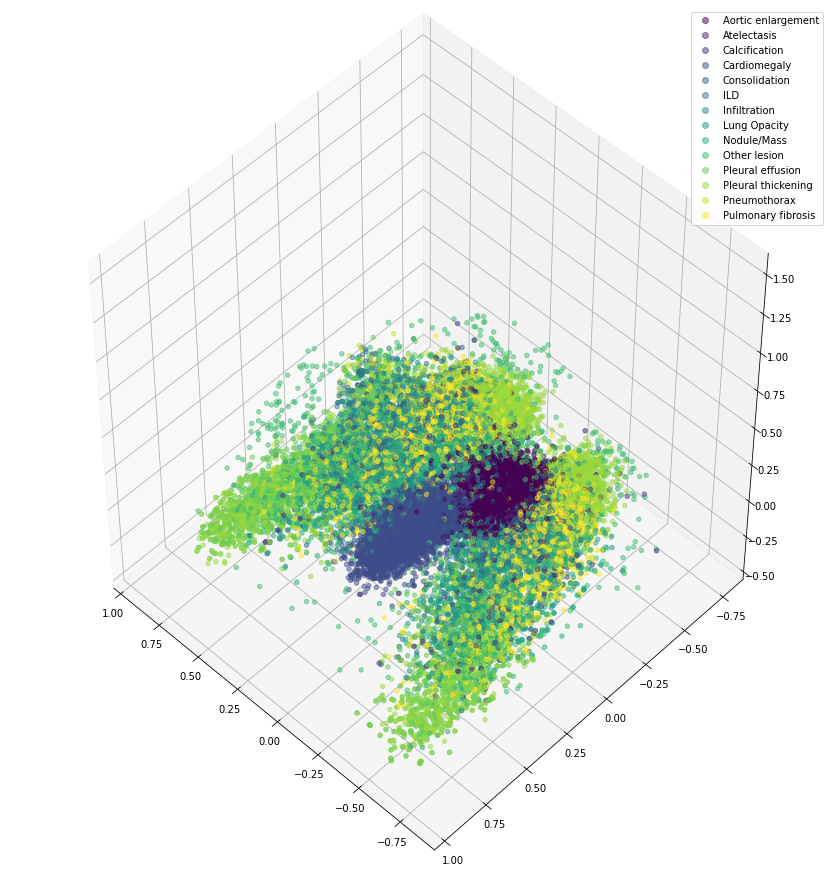

In [ ]:
fig = plt.figure(figsize = (12, 12))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
plt.cla()
scatter = ax.scatter3D(plot_x, plot_y, plot_z, c=data_y.tolist(), alpha= 0.5,cmap='viridis')
ax.legend(handles=scatter.legend_elements()[0], labels=classes)

In [ ]:
import plotly.express as px

fig = px.scatter_3d(x = plot_x, y = plot_y, z = plot_z, color=train_df['class_name'])
fig.update_layout(title='PCA', autosize=False,
                  width=800, height=800,
                  showlegend= True,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()


### 2.4 Visualización t-SNE de la distribución de las clases según la ubicación de los bounding boxes.

Realizamos un análisis t-SNE introduciendo como datos de entrada las coordenadas X e Y, el alto y ancho y largo de los bounding boxes y al área de estos. De este modo sacaremos la proximidad entre las clases a predecir o clasificar.

In [ ]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, perplexity = 40, random_state=1, n_iter=5000)
data_X = X
data_y = y.loc[data_X.index]
embs = tsne.fit_transform(data_X)
# Add to dataframe for convenience
plot_x = embs[:, 0]
plot_y = embs[:, 1]

CPU times: user 48min 5s, sys: 3.56 s, total: 48min 9s
Wall time: 24min 22s


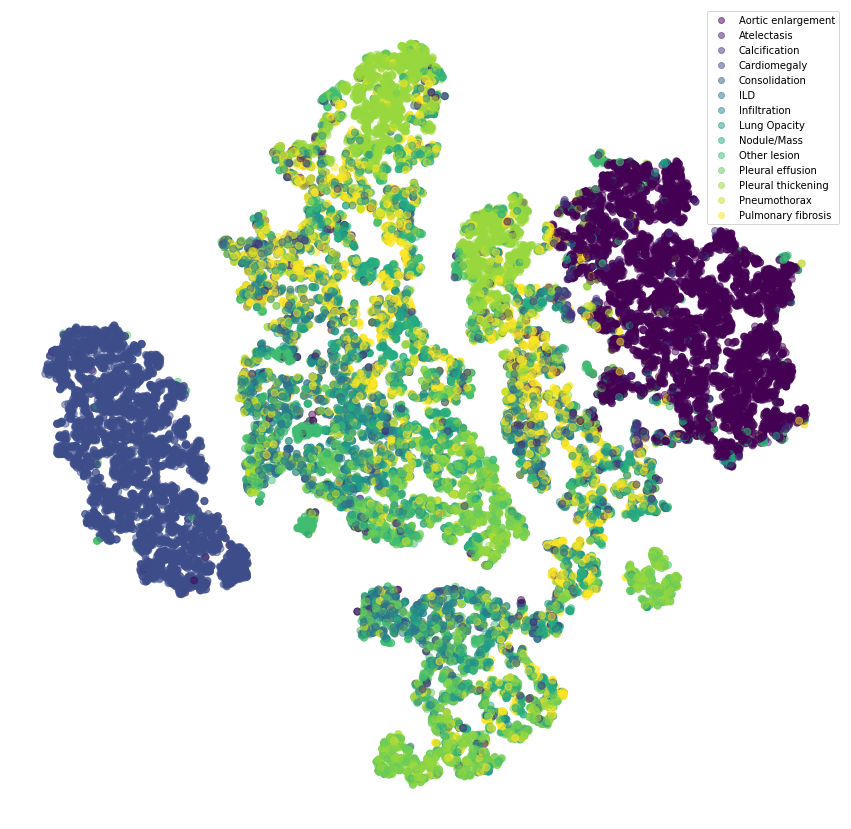

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 15))
plt.axis('off')
scatter = plt.scatter(plot_x, plot_y, marker = 'o',s = 50, c=data_y.tolist(), alpha= 0.5,cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

### 2.5 Dividimos el dataset en train y val

In [ ]:
gkf  = GroupKFold(n_splits = 5)
train_df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups = train_df.image_id.tolist())):
    train_df.loc[val_idx, 'fold'] = fold
train_df.head()

image_id          class_name  ...      area fold
0  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly  ...  0.090283    3
1  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement  ...  0.014433    2
2  1c32170b4af4ce1a3030eb8167753b06  Pleural thickening  ...  0.003117    4
3  0c7a38f293d5f5e4846aa4ca6db4daf1                 ILD  ...  0.277156    2
4  47ed17dcb2cbeec15182ed335a8b5a9e         Nodule/Mass  ...  0.001809    4

[5 rows x 17 columns]

In [ ]:
train_files = []
val_files   = []
val_files += list(train_df[train_df.fold==fold].image_path.unique())
train_files += list(train_df[train_df.fold!=fold].image_path.unique())
len(train_files), len(val_files)

(3515, 879)

### 2.6 Dividimos las etiquetas y las imágenes en las carpetas correspondientes.

In [ ]:
os.makedirs('/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/labels/train', exist_ok = True)
os.makedirs('/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/labels/val', exist_ok = True)
os.makedirs('/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/images/train', exist_ok = True)
os.makedirs('/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/images/val', exist_ok = True)
label_dir = '/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/vbd-yololabels-dataset/labels'
for file in tqdm(train_files):
    shutil.copy(file, '/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/images/train')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), '/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/labels/train')
    
for file in tqdm(val_files):
    shutil.copy(file, '/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/images/val')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), '/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/labels/val')

### 2.7 Obtenemos la lista de clases.

In [ ]:
class_ids, class_names = list(zip(*set(zip(train_df.class_id, train_df.class_name))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
classes

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

## 3 Entrenamiento del modelo YOLOv5 

In [ ]:
from os import listdir
from os.path import isfile, join
import yaml

cwd = '/content/drive/MyDrive/000_PROYECTO DL/'

with open(join( cwd , 'train.txt'), 'w') as f:
    for path in glob('/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/images/train/*'):
        f.write(path+'\n')
            
with open(join( cwd , 'val.txt'), 'w') as f:
    for path in glob('/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/images/val/*'):
        f.write(path+'\n')

data = dict(
    train =  join( cwd , 'train.txt') ,
    val   =  join( cwd , 'val.txt' ),
    nc    = 14,
    names = classes
    )

with open(join( cwd , 'vinbigdata.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(join( cwd , 'vinbigdata.yaml'), 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- Aortic enlargement
- Atelectasis
- Calcification
- Cardiomegaly
- Consolidation
- ILD
- Infiltration
- Lung Opacity
- Nodule/Mass
- Other lesion
- Pleural effusion
- Pleural thickening
- Pneumothorax
- Pulmonary fibrosis
nc: 14
train: /content/drive/MyDrive/000_PROYECTO DL/train.txt
val: /content/drive/MyDrive/000_PROYECTO DL/val.txt



In [ ]:
# https://www.kaggle.com/ultralytics/yolov5
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
shutil.copytree('/content/yolov5', '/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/yolov5')
os.chdir('/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/yolov5')
%pip install -qr requirements.txt # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.7.0+cu101 _CudaDeviceProperties(name='Tesla P4', major=6, minor=1, total_memory=7611MB, multi_processor_count=20)


In [ ]:
!WANDB_MODE="dryrun" python train.py --img 640 --batch 16 --epochs 30 --data '/content/drive/MyDrive/000_PROYECTO DL/vinbigdata.yaml' --weights yolov5s.pt --cache

github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 v4.0-104-gefa4946 torch 1.7.0+cu101 CUDA:0 (Tesla P4, 7611.9375MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='', data='/content/drive/MyDrive/000_PROYECTO DL/vinbigdata.yaml', device='', entity=None, epochs=30, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[640, 640], linear_lr=False, local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp', single_cls=False, sync_bn=False, total_batch_size=16, weights='yolov5s.pt', workers=8, world_size=1)
wandb: Install Weights & Biases for YOLOv5 logging with 'pip install wandb' (recommended)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
2021-02-26 10:55:42.415396: I tensorflow/stream_executor/pl

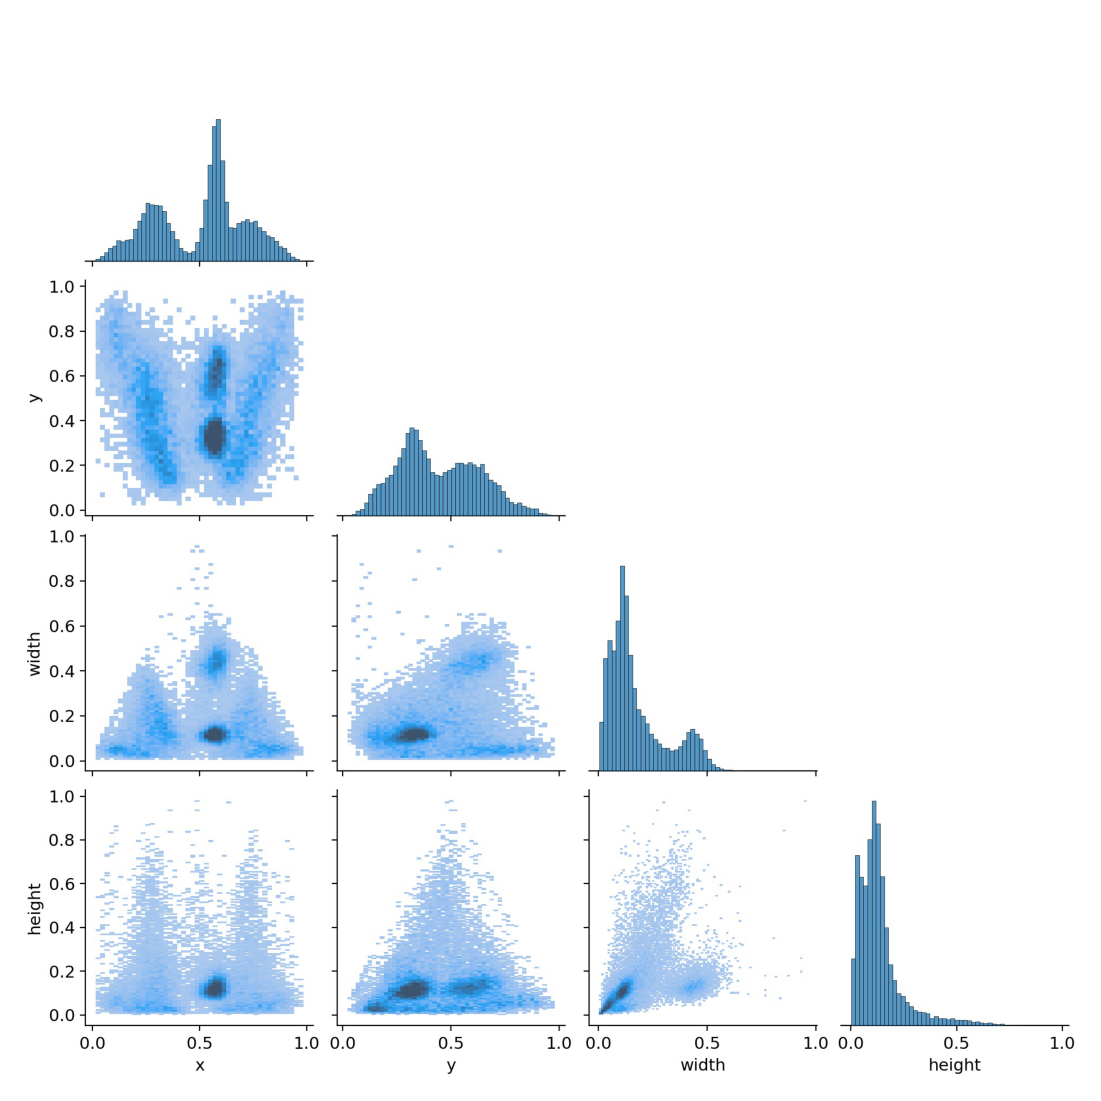

In [ ]:
os.chdir('/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/yolov5')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/labels_correlogram.jpg'))

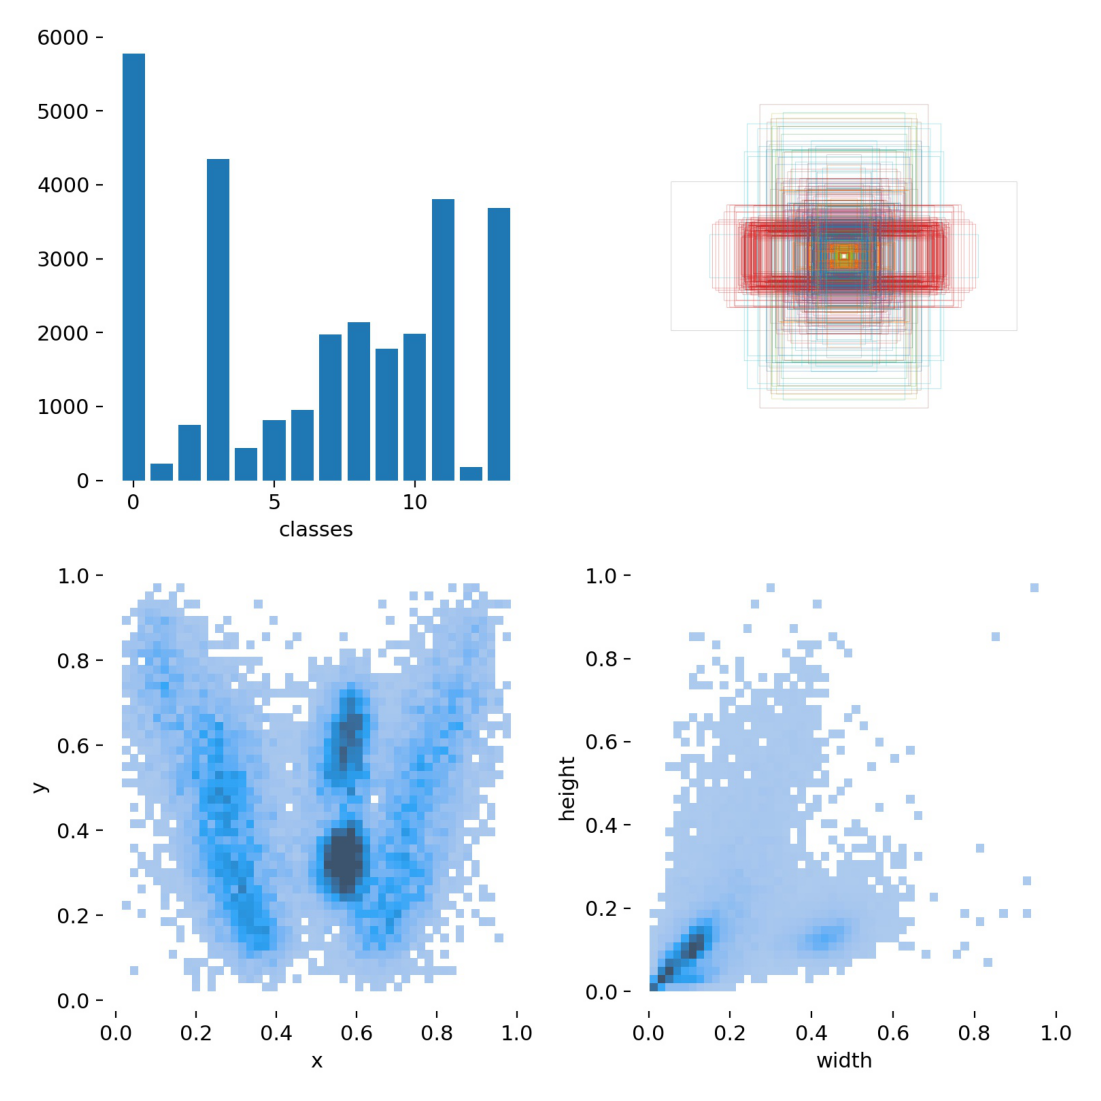

In [ ]:
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/labels.jpg'))

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15, 15))
plt.imshow(plt.imread('runs/train/exp/train_batch0.jpg'))

plt.figure(figsize = (15, 15))
plt.imshow(plt.imread('runs/train/exp/train_batch1.jpg'))

plt.figure(figsize = (15, 15))
plt.imshow(plt.imread('runs/train/exp/train_batch2.jpg'))

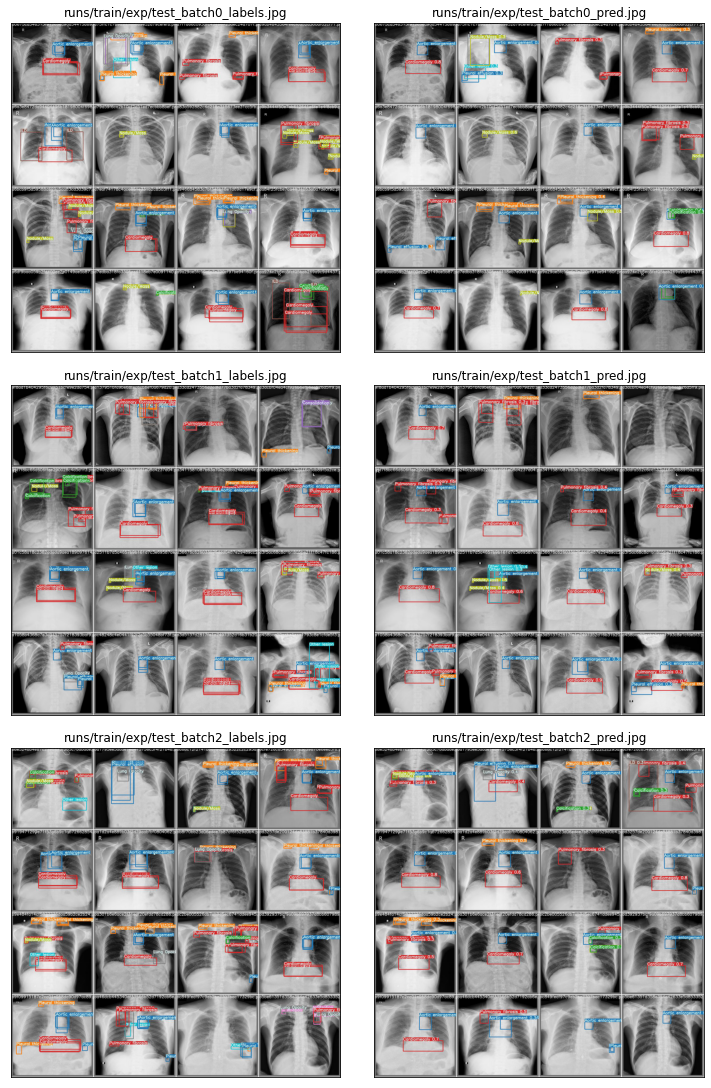

In [ ]:
fig, ax = plt.subplots(3, 2, figsize = (2*5,3*5), constrained_layout = True)
for row in range(3):
    ax[row][0].imshow(plt.imread(f'runs/train/exp/test_batch{row}_labels.jpg'))
    ax[row][0].set_xticks([])
    ax[row][0].set_yticks([])
    ax[row][0].set_title(f'runs/train/exp/test_batch{row}_labels.jpg', fontsize = 12)
    
    ax[row][1].imshow(plt.imread(f'runs/train/exp/test_batch{row}_pred.jpg'))
    ax[row][1].set_xticks([])
    ax[row][1].set_yticks([])
    ax[row][1].set_title(f'runs/train/exp/test_batch{row}_pred.jpg', fontsize = 12)

### 3.1 Resultados

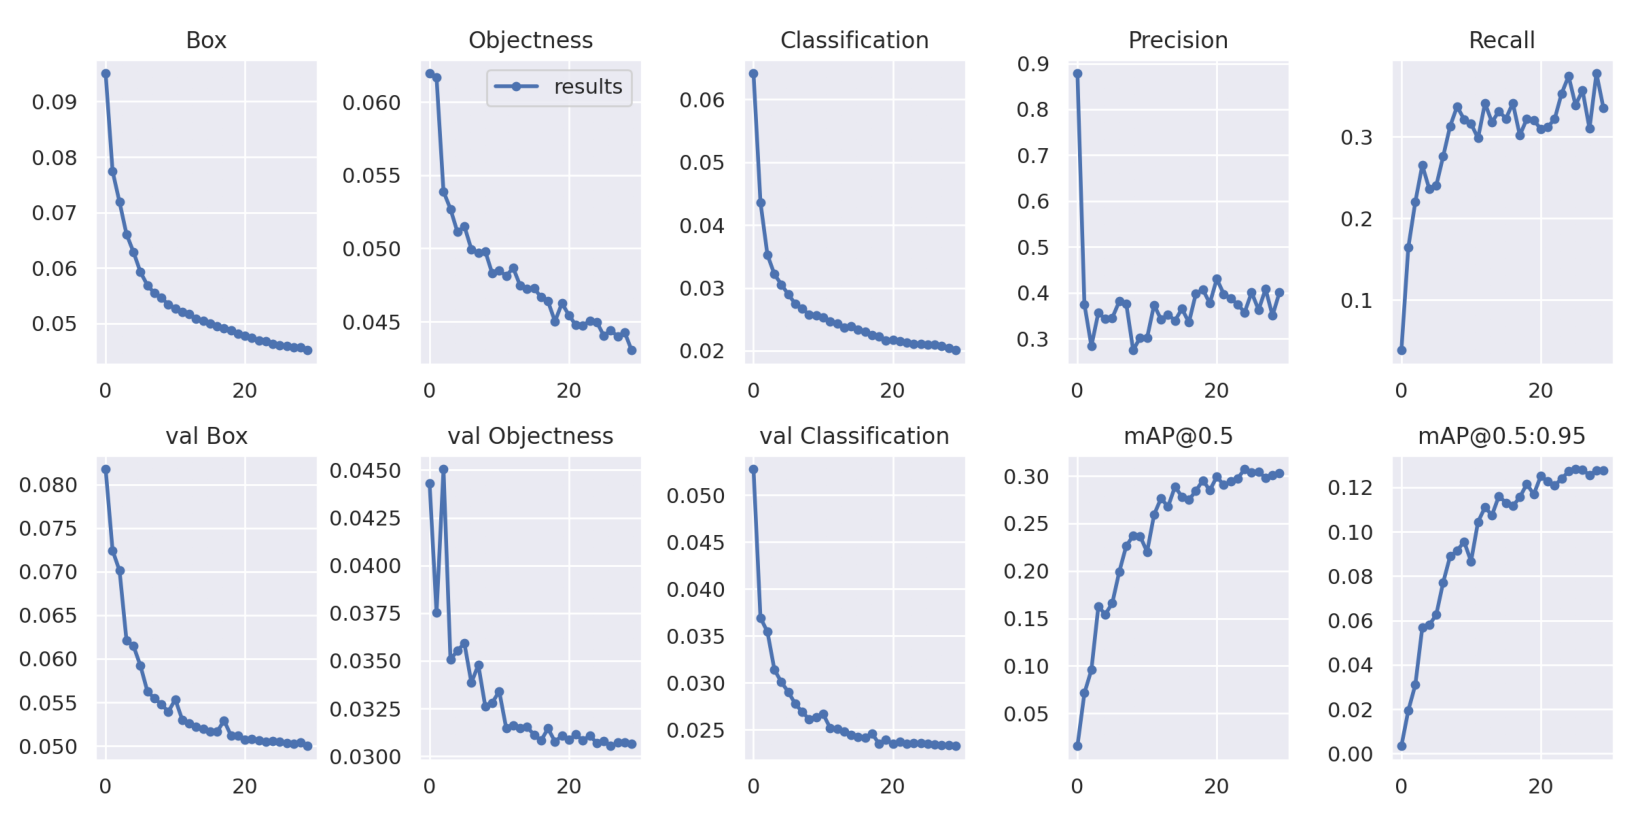

In [ ]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/results.png'))

### 3.2 Confusion matrix

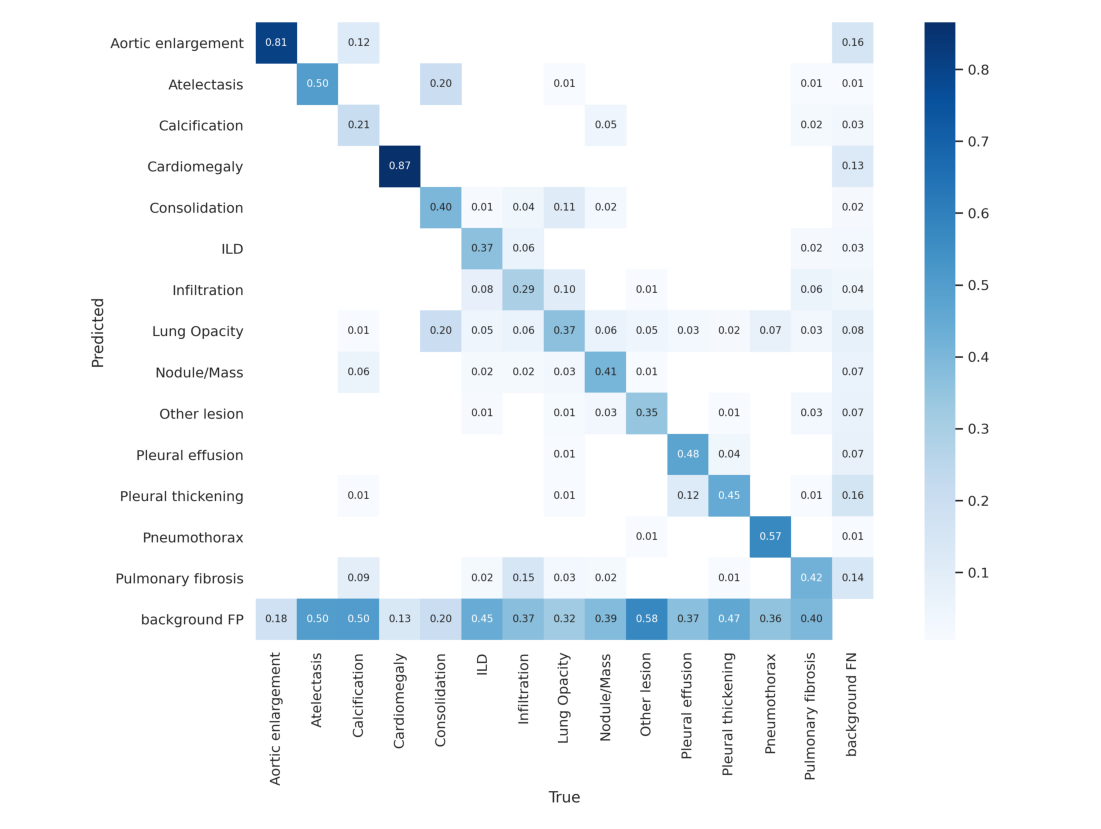

In [ ]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/confusion_matrix.png'))

In [ ]:
!python detect.py --weights 'runs/train/exp/weights/best.pt' --img 640 --conf 0.15 --iou 0.5 --source '/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/images/val' --exist-ok

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.15, device='', exist_ok=True, img_size=640, iou_thres=0.5, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/images/val', update=False, view_img=False, weights=['runs/train/exp/weights/best.pt'])
YOLOv5 v4.0-104-gefa4946 torch 1.7.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 224 layers, 7088971 parameters, 0 gradients, 16.4 GFLOPS
image 1/879 /content/drive/MyDrive/000_PROYECTO DL/vinbigdata/images/val/00675cd546313f912cadd4ad54415d69.png: 640x640 1 Aortic enlargement, 1 Cardiomegaly, 1 Pleural thickening, Done. (0.012s)
image 2/879 /content/drive/MyDrive/000_PROYECTO DL/vinbigdata/images/val/009d4c31ebf87e51c5c8c160a4bd8006.png: 640x640 1 Aortic enlargement, 1 Lung Opacity, 1 Pleural effusion, Done. (0.012s)
image 3/879 /content/drive/MyDrive/000_PROYECTO DL/vinbigdata/images/val/00bcb82818ea83d6a86df241762cd7d0.

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random
import cv2
from glob import glob
from tqdm import tqdm

files = glob('runs/detect/exp/*')
for _ in range(3):
    row = 4
    col = 4
    grid_files = random.sample(files, row*col)
    images     = []
    for image_path in tqdm(grid_files):
        img          = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        images.append(img)

    fig = plt.figure(figsize=(col*5, row*5))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(col, row),  # creates 2x2 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

### 3.3 TEST

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/test.csv')
test_df.head()

image_id  width  height
0  83caa8a85e03606cf57e49147d7ac569   2304    2880
1  7550347fa2bb96c2354a3716dfa3a69c   2538    3095
2  74b23792db329cff5843e36efb8aa65a   2788    3120
3  94568a546be103177cb582d3e91cd2d8   1994    2430
4  6da36354fc904b63bc03eb3884e0c35c   2056    2376

In [ ]:
!python detect.py --weights '/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/yolov5/runs/train/exp/weights/best.pt' --img 640 --conf 0.15 --iou 0.4 --source '/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/test' --save-txt --save-conf --exist-ok

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.15, device='', exist_ok=True, img_size=640, iou_thres=0.4, name='exp', project='runs/detect', save_conf=True, save_txt=True, source='/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/test', update=False, view_img=False, weights=['/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/yolov5/runs/train/exp/weights/best.pt'])
YOLOv5 v4.0-104-gefa4946 torch 1.7.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
Model Summary: 224 layers, 7088971 parameters, 0 gradients, 16.4 GFLOPS
image 1/3000 /content/drive/MyDrive/000_PROYECTO DL/vinbigdata/test/002a34c58c5b758217ed1f584ccbcfe9.png: 640x640 1 Cardiomegaly, 1 Pleural thickening, Done. (0.012s)
image 2/3000 /content/drive/MyDrive/000_PROYECTO DL/vinbigdata/test/004f33259ee4aef671c2b95d54e4be68.png: 640x640 1 Aortic enlargement, Done. (0.012s)
image 3/3000 /content/drive/MyDrive/000_PROYECTO DL/vinbigdata/test/008bdde2af2462e86fd373a445d0f4cd.png: 640x640 1 Aortic en

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random
import cv2
from glob import glob
from tqdm import tqdm

os.chdir('/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/yolov5')
files = glob('runs/detect/exp/*png')
for _ in range(3):
    row = 4
    col = 4
    grid_files = random.sample(files, row*col)
    images     = []
    for image_path in tqdm(grid_files):
        img          = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        images.append(img)

    fig = plt.figure(figsize=(col*5, row*5))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(col, row),  # creates 2x2 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [ ]:
def yolo2voc(image_height, image_width, bboxes):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y1]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    
    return bboxes

In [ ]:
image_ids = []
PredictionStrings = []

for file_path in tqdm(glob('runs/detect/exp/labels/*txt')):
    image_id = file_path.split('/')[-1].split('.')[0]
    w, h = test_df.loc[test_df.image_id==image_id,['width', 'height']].values[0]
    f = open(file_path, 'r')
    data = np.array(f.read().replace('\n', ' ').strip().split(' ')).astype(np.float32).reshape(-1, 6)
    data = data[:, [0, 5, 1, 2, 3, 4]]
    bboxes = list(np.round(np.concatenate((data[:, :2], np.round(yolo2voc(h, w, data[:, 2:]))), axis =1).reshape(-1), 1).astype(str))
    for idx in range(len(bboxes)):
        bboxes[idx] = str(int(float(bboxes[idx]))) if idx%6!=1 else bboxes[idx]
    image_ids.append(image_id)
    PredictionStrings.append(' '.join(bboxes))

100%|██████████| 2264/2264 [00:05<00:00, 446.14it/s]


In [ ]:
pred_df = pd.DataFrame({'image_id':image_ids,
                        'PredictionString':PredictionStrings})
sub_df = pd.merge(test_df, pred_df, on = 'image_id', how = 'left').fillna("14 1 0 0 1 1")
sub_df = sub_df[['image_id', 'PredictionString']]
sub_df.to_csv('/content/drive/MyDrive/000_PROYECTO DL/vinbigdata/submission.csv',index = False)
sub_df.tail()

image_id                                   PredictionString
2995  7f5503caa936a623b4388fbd88e890c5                           0 0.7 1383 799 1646 1096
2996  c97e54a78bab9c05ce2e04fe6c284bcd  3 0.6 1356 1704 2418 2028 0 0.8 1710 996 2070 ...
2997  33218cf183c1224a74ccfb514e827e15   13 0.2 493 1562 607 1612 7 0.3 520 681 1095 1562
2998  04b700c4815f088728db9f093c739707  11 0.3 679 586 1033 694 0 0.5 1310 1065 1582 1370
2999  14da9051525bd2504dd56938f92644ef                           0 0.4 1001 812 1200 1030